# Cluster exploration and feature importance

This notebook assesses overall similarity of clusters based on Ward's agglomerative clustering and uses Random Forest model to explore the importance of individual characters.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import dask.dataframe
import matplotlib.pyplot as plt
import urbangrammar_graphics as ugg

from matplotlib.lines import Line2D
from sklearn.ensemble import RandomForestClassifier

In [2]:
%time standardized_form = dask.dataframe.read_parquet("../../urbangrammar_samba/spatial_signatures/clustering_data/form/standardized/").set_index('hindex')
%time stand_fn = dask.dataframe.read_parquet("../../urbangrammar_samba/spatial_signatures/clustering_data/function/standardized/")
%time data = dask.dataframe.multi.concat([standardized_form, stand_fn], axis=1).replace([np.inf, -np.inf], np.nan).fillna(0)
%time data = data.drop(columns=["keep_q1", "keep_q2", "keep_q3"])
%time data = data.compute()

CPU times: user 38.5 s, sys: 33.9 s, total: 1min 12s
Wall time: 1min 43s
CPU times: user 73.3 ms, sys: 81.5 ms, total: 155 ms
Wall time: 227 ms
CPU times: user 43.1 ms, sys: 6.71 ms, total: 49.8 ms
Wall time: 42.6 ms
CPU times: user 18.7 ms, sys: 0 ns, total: 18.7 ms
Wall time: 18.6 ms
CPU times: user 2min 42s, sys: 1min 28s, total: 4min 10s
Wall time: 2min 47s


In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14539578 entries, c000e094707t0000 to c102e644989t0115
Columns: 328 entries, sdbAre_q1 to Code_18_521_q3
dtypes: float64(328)
memory usage: 35.6+ GB


In [3]:
labels_l1 = pd.read_parquet("../../urbangrammar_samba/spatial_signatures/clustering_data/KMeans10GB.pq")
labels_l1

kmeans10gb
hindex                      
c000e094707t0000           4
c000e094763t0000           0
c000e094763t0001           0
c000e094763t0002           0
c000e094764t0000           0
...                      ...
c102e644989t0111           0
c102e644989t0112           0
c102e644989t0113           0
c102e644989t0114           0
c102e644989t0115           0

[14539578 rows x 1 columns]

In [4]:
labels_l2_9 = pd.read_parquet("../../urbangrammar_samba/spatial_signatures/clustering_data/clustergram_cl9_labels.pq")
labels_l2_9

1  2  3  4  5  6  7  8  9  10  ...  15  16  17  18  19  20  21  22  \
0       0  0  0  0  0  0  0  0  0   0  ...  14   4  10   2  11   6   6  18   
1       0  0  0  0  0  0  0  0  0   0  ...  14   4  10   2  11   6   6  18   
2       0  0  0  0  0  0  0  0  0   0  ...  14   4  10   2  11   6   6  18   
3       0  0  0  0  0  0  0  0  0   0  ...  14   4  10   2  11   6   6  18   
4       0  0  0  0  0  0  0  0  0   0  ...  14   4  10   2  11   6   6  18   
...    .. .. .. .. .. .. .. .. ..  ..  ...  ..  ..  ..  ..  ..  ..  ..  ..   
113639  0  0  0  0  0  0  0  0  0   0  ...  14   4  10   2  11   6   6  18   
113640  0  0  0  0  0  0  0  0  0   0  ...  14   4  10   2  11   6   6  18   
113641  0  0  0  0  0  0  0  0  0   0  ...  14   4  10   2  11   6   6  18   
113642  0  0  0  0  0  0  0  0  0   0  ...  14   4  10   2  11   6   6  18   
113643  0  0  0  0  0  0  0  0  0   0  ...  14   4  10   2  11   6   6  18   

        23  24  
0       22  13  
1       22  13  
2       22  13  
3       22  13  
4       22  13  
...     ..  ..  
113639  22  13  
113640  22  13  
113641  22  13  
113642  22  13  
113643  22  13  

[113644 rows x 24 columns]

In [5]:
labels_l2_2 = pd.read_parquet("../../urbangrammar_samba/spatial_signatures/clustering_data/subclustering_cluster2_k3.pq")
labels_l2_2

subclustering_cluster2_k3
hindex                                     
c000e097919t0003                          1
c000e097919t0005                          1
c000e097919t0008                          1
c000e097919t0009                          1
c000e097919t0015                          1
...                                     ...
c102e639766t0007                          0
c102e639766t0010                          0
c102e639766t0011                          0
c102e639766t0012                          0
c102e639766t0013                          0

[1115564 rows x 1 columns]

In [6]:
labels = labels_l1.copy()
labels.loc[labels.kmeans10gb == 9, 'kmeans10gb'] = labels_l2_9['9'].values + 90
labels.loc[labels.kmeans10gb == 2, 'kmeans10gb'] = labels_l2_2['subclustering_cluster2_k3'].values + 20

In [7]:
labels.kmeans10gb.value_counts()

7     3686554
0     3022385
3     2561211
1     1962830
5      707211
4      595902
8      564318
20     502835
21     374090
22     238639
6      209959
90      86380
92      21760
94       3739
91       1390
95        264
97         98
98          8
93          3
96          2
Name: kmeans10gb, dtype: int64

In [8]:
outliers = [98, 93, 96, 97]
mask = ~labels.kmeans10gb.isin(outliers)

## Overall similarity

Similarity of clusters can be represented by hierarchical dendrogram generated using Ward's agglomerative clustering.

In [50]:
from scipy.cluster import hierarchy

group = data.loc[mask].groupby(labels.loc[mask]['kmeans10gb'].values).mean() # cluster centroids
median = data.loc[mask].groupby(labels.loc[mask]['kmeans10gb'].values).median()

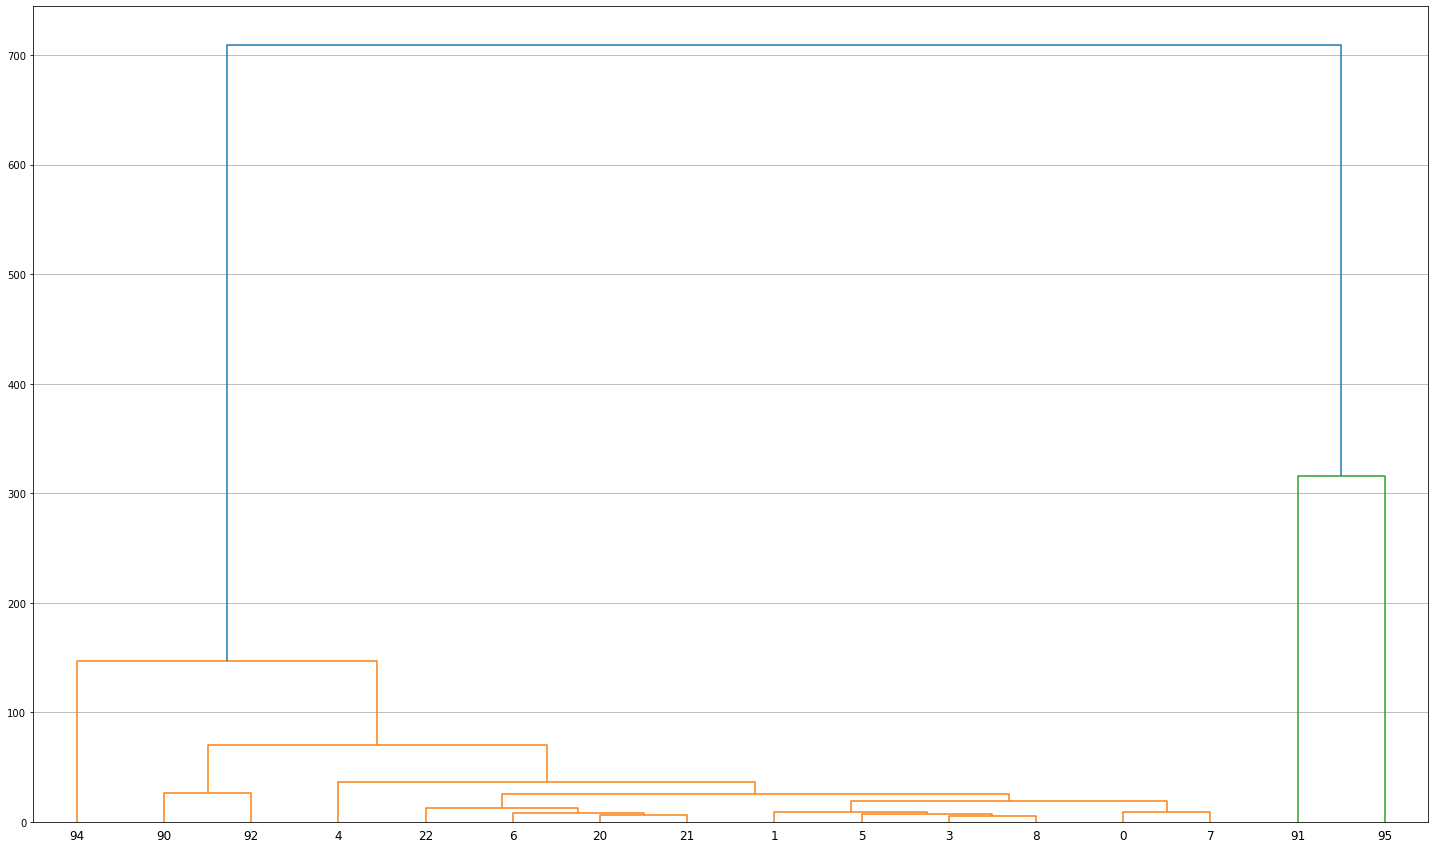

In [ ]:
Z = hierarchy.linkage(group, 'ward')
fig, ax = plt.subplots(figsize=(25, 15))
dn = hierarchy.dendrogram(Z, labels=group.index)
plt.grid(True, axis='y', which='both')

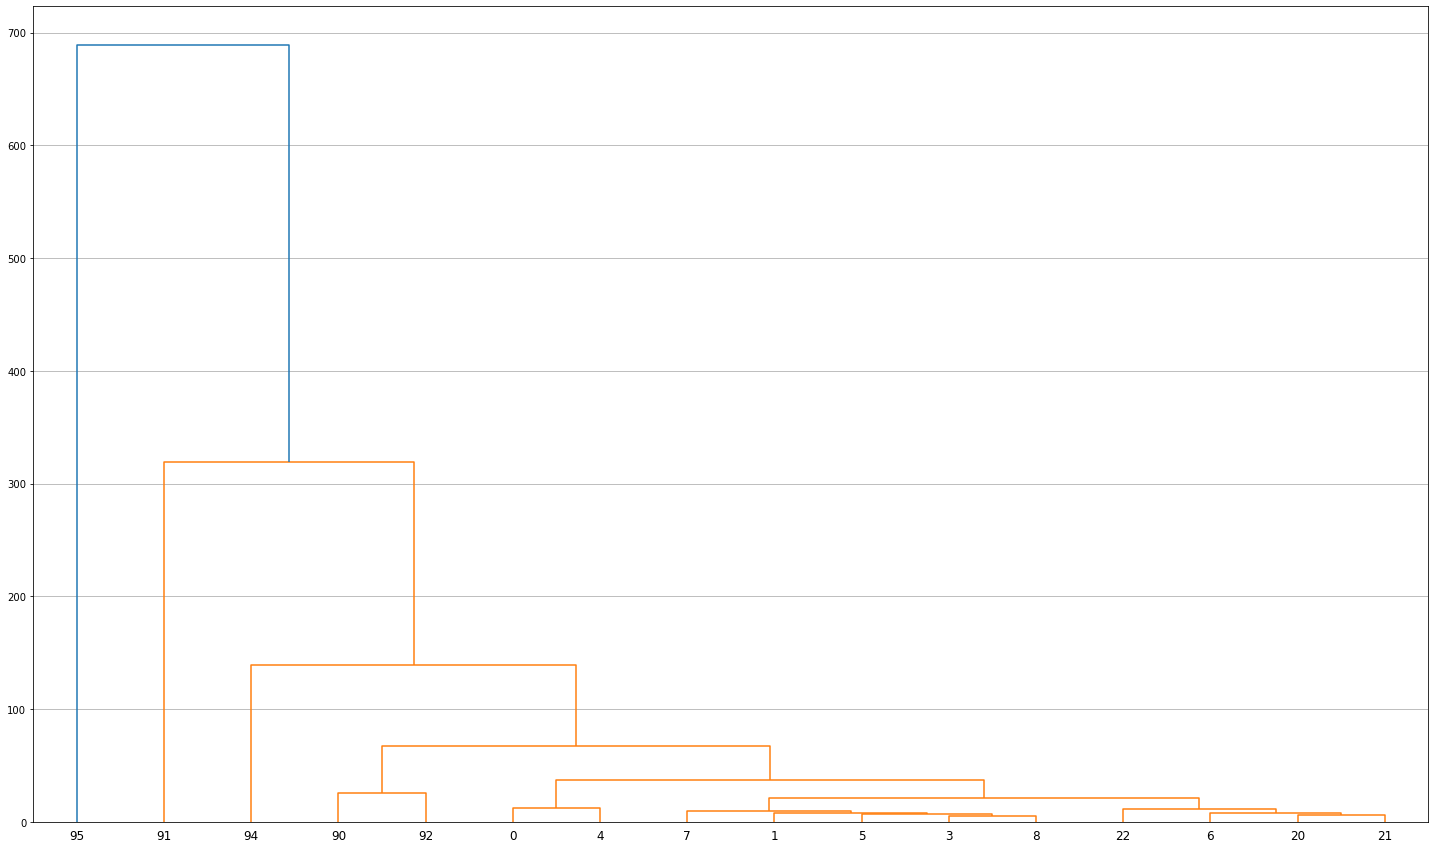

In [ ]:
Z = hierarchy.linkage(median, 'ward')
fig, ax = plt.subplots(figsize=(25, 15))
dn = hierarchy.dendrogram(Z, labels=group.index)
plt.grid(True, axis='y', which='both')

## Global feature importance

Feature importance indicates which characters are more important in distinguishing between the signature types.

In [11]:
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, verbose=1)
%time clf = clf.fit(data.loc[mask].values, labels.loc[mask]['kmeans10gb'].values)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 23.0min


CPU times: user 19h 19min 43s, sys: 2min 14s, total: 19h 21min 57s
Wall time: 1h 19min 23s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 79.0min finished


In [ ]:
# DO NOT RUN, KILLS THE KERNEL ON OUT OF MEMORY
# clf.score(data.loc[mask].values, labels.loc[mask]['kmeans10gb'].values)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


In [12]:
importances = clf.feature_importances_

In [52]:
clf

RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

In [54]:
std = np.std([clf.feature_importances_ for tree in clf.estimators_], axis=0)

In [86]:
to_plot = pd.DataFrame({"std": std, "imp": clf.feature_importances_}, index=data.columns).sort_values("imp", ascending=False)
to_plot

std       imp
sicCAR_q1       4.857226e-17  0.036944
sicCAR_q2       7.632783e-17  0.031717
mtcWNe_q2       3.122502e-17  0.023476
ltbIBD_q2       1.040834e-17  0.016662
sdcAre_q3       3.122502e-17  0.016005
...                      ...       ...
Code_18_334_q2  0.000000e+00  0.000000
Code_18_141_q1  0.000000e+00  0.000000
Code_18_124_q1  0.000000e+00  0.000000
Code_18_511_q2  0.000000e+00  0.000000
Code_18_521_q3  0.000000e+00  0.000000

[328 rows x 2 columns]

In [94]:
to_plot['ff'] = pd.Series(to_plot.index).apply(lambda x: "form" if x in data.columns[:177] else "function").values

In [98]:
to_plot["q"] = pd.Series(to_plot.index).apply(lambda x: x[-2:]).values

In [107]:
to_plot.ff.isna().any()

False

<AxesSubplot:xlabel='imp'>

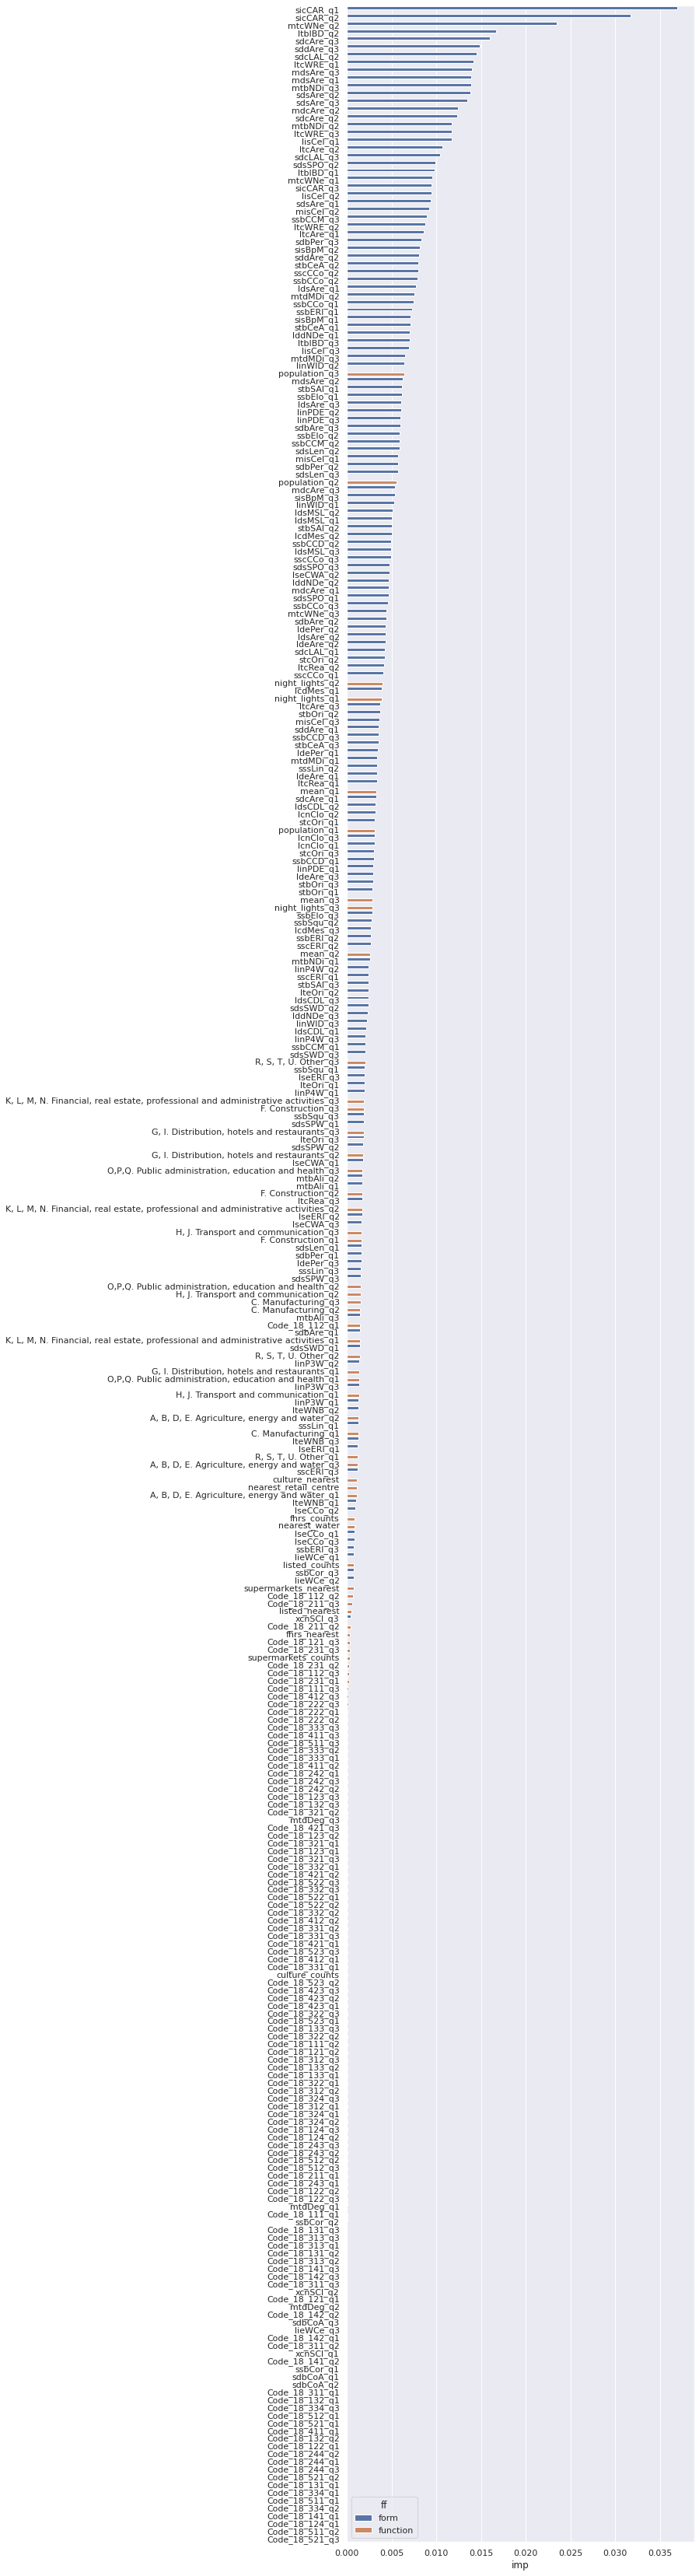

In [ ]:
import seaborn
seaborn.set()
fig, ax = plt.subplots(figsize=(8, 60))

seaborn.barplot(x='imp', y=to_plot.index, hue='ff', data=to_plot)

In [13]:
importances = pd.Series(importances.flatten(), index=data.columns).sort_values(ascending=False)

In [71]:
importances.tail(50)

Code_18_512_q2    4.999057e-05
Code_18_512_q3    4.940122e-05
Code_18_211_q1    4.870476e-05
Code_18_243_q1    4.857090e-05
Code_18_122_q2    4.713622e-05
Code_18_122_q3    4.587244e-05
mtdDeg_q1         4.007576e-05
Code_18_111_q1    3.632193e-05
ssbCor_q2         2.848661e-05
Code_18_131_q3    2.597117e-05
Code_18_313_q3    2.332676e-05
Code_18_313_q1    2.211369e-05
Code_18_131_q2    2.180273e-05
Code_18_313_q2    2.172385e-05
Code_18_141_q3    1.715724e-05
Code_18_142_q3    1.472706e-05
Code_18_311_q3    1.048974e-05
xcnSCl_q2         8.842498e-06
Code_18_121_q1    7.240644e-06
mtdDeg_q2         4.812494e-06
Code_18_142_q2    3.522273e-06
sdbCoA_q3         1.751870e-06
lieWCe_q3         1.667145e-06
Code_18_142_q1    1.139103e-06
Code_18_311_q2    5.870861e-07
xcnSCl_q1         1.686649e-07
Code_18_141_q2    1.031014e-07
ssbCor_q1         1.004750e-07
sdbCoA_q1         6.751301e-08
sdbCoA_q2         3.984640e-08
Code_18_311_q1    1.889368e-08
Code_18_132_q1    0.000000e+00
Code_18_

In [26]:
importances.iloc[150:200]

O,P,Q. Public administration, education and health_q3                                0.001755
mtbAli_q2                                                                            0.001747
mtbAli_q1                                                                            0.001720
F. Construction_q2                                                                   0.001702
ltcRea_q3                                                                            0.001690
K, L, M, N. Financial, real estate, professional and administrative activities_q2    0.001687
lseERI_q2                                                                            0.001680
lseCWA_q3                                                                            0.001677
H, J. Transport and communication_q3                                                 0.001675
F. Construction_q1                                                                   0.001672
sdsLen_q1                                                   

In [24]:
importances

sicCAR_q1         0.036944
sicCAR_q2         0.031717
mtcWNe_q2         0.023476
ltbIBD_q2         0.016662
sdcAre_q3         0.016005
                    ...   
Code_18_334_q2    0.000000
Code_18_141_q1    0.000000
Code_18_124_q1    0.000000
Code_18_511_q2    0.000000
Code_18_521_q3    0.000000
Length: 328, dtype: float64

In [21]:
importances.to_csv("../../urbangrammar_samba/spatial_signatures/clustering_data/spsig_feature_importance.csv")

### Extremes

To better understand the important characters, it is useful to check their actual values.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 200))
sns.heatmap(group.T, cmap="vlag", center=0, annot=True, cbar=False)
# plt.savefig("../../urbangrammar_samba/spatial_signatures/clustering_data/spsig_heatmap.pdf", bbox_inches="tight")

<AxesSubplot:>

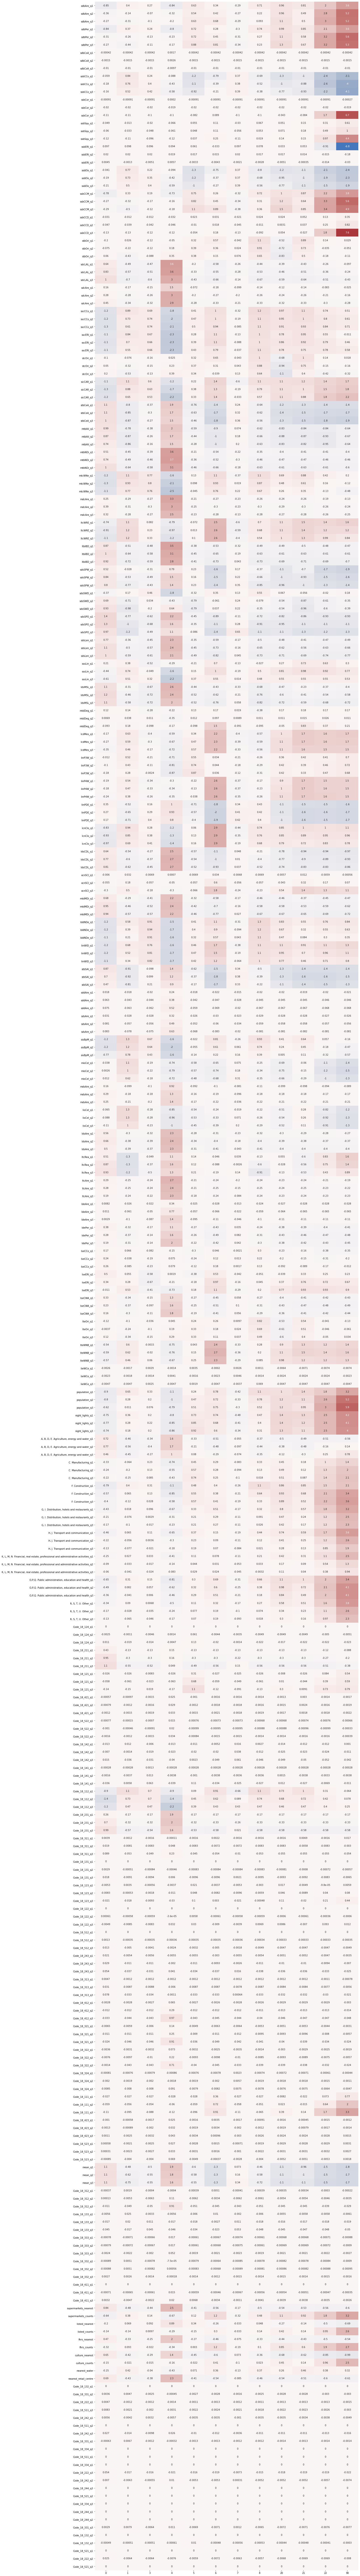

In [ ]:
fig, ax = plt.subplots(figsize=(20, 200))
sns.heatmap(group.T.iloc[:, :-4], cmap="vlag", center=0, annot=True, cbar=False)
plt.savefig("../../urbangrammar_samba/spatial_signatures/clustering_data/spsig_heatmap_no_centers.pdf", bbox_inches="tight")